In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import utils

from sklearn import svm, ensemble
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import sklearn.multiclass
import sklearn.ensemble

from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled

In [2]:
path_to_train_data = "data/imclef07d/imclef07d_train.csv"
path_to_test_data = "data/imclef07d/imclef07d_test.csv"

path_to_data_hf = "data/imclef07d/imclef07d.hf"

path_to_class_hierarchy = 'data/imclef07d/class_hierarchy.json'

In [3]:
df_train = pd.read_csv(path_to_train_data, index_col=0)
df_train['labels'] = df_train['labels'].apply(lambda x: x.split(','))

In [4]:
df_test = pd.read_csv(path_to_test_data, index_col=0)
df_test['labels'] = df_test['labels'].apply(lambda x: x.split(','))

In [5]:
with open(path_to_class_hierarchy, 'r') as f:
    class_hierarchy = json.load(f)
    
class_hierarchy[ROOT] = class_hierarchy['19'] 
class_hierarchy.pop('19')
pass

In [6]:
y_train = df_train['labels']
X_train = df_train.drop(columns=['labels'])

y_test = df_test['labels']
X_test = df_test.drop(columns=['labels'])

In [7]:
base_estimator = make_pipeline(
    TruncatedSVD(n_components=3),
    svm.SVC(
        gamma='scale',
        kernel="sigmoid",
        probability=True
    ),
)
clf_lcpn = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=class_hierarchy,
    algorithm='lcpn'
)
clf_lcpn.fit(X_train[:10], y_train.apply(lambda x: x[-1])[:10])
graph = clf_lcpn.graph_

_train_local_classifier() - not enough training data available to train, classification in branch will terminate at node 16
_train_local_classifier() - not enough training data available to train, classification in branch will terminate at node 1A
_train_local_classifier() - not enough training data available to train, classification in branch will terminate at node 1B
_train_local_classifier() - not enough training data available to train, classification in branch will terminate at node 1C
_train_local_classifier() - not enough training data available to train, classification in branch will terminate at node 2
_train_local_classifier() - not enough training data available to train, classification in branch will terminate at node 3
_train_local_classifier() - not enough training data available to train, classification in branch will terminate at node 7
_train_local_classifier() - not enough training data available to train, classification in branch will terminate at node A
_train_local

In [8]:
def classify(X_train, y_train, X_test, y_test, class_hierarchy, graph, clf, mlb=None):
    if mlb is not None:
        y_train = mlb.fit_transform(y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if mlb is not None:
        y_pred = mlb.inverse_transform(y_pred)
    with multi_labeled(y_test, y_pred, graph) as (y_test_, y_pred_, graph_):
        h_fbeta = h_fbeta_score(
            y_test_,
            y_pred_,
            graph_,
        )
    return {'h_fbeta': h_fbeta}


def lcpn(X_train, y_train, X_test, y_test, class_hierarchy, graph, base_estimator):
    clf_lcpn = HierarchicalClassifier(
        base_estimator=base_estimator,
        class_hierarchy=class_hierarchy,
        algorithm='lcpn'
    )
    return classify(X_train, y_train.apply(lambda x: x[-1]), X_test, y_test.apply(lambda x: x[-1]), class_hierarchy, graph, clf_lcpn)


def lcn(X_train, y_train, X_test, y_test, class_hierarchy, graph, base_estimator):
    mlb = sklearn.preprocessing.MultiLabelBinarizer()
    clf_lcn = sklearn.multiclass.OneVsRestClassifier(estimator=base_estimator)
    return classify(X_train, y_train, X_test, y_test, class_hierarchy, graph, clf_lcn, mlb=mlb)


def lcl(X_train, y_train, X_test, y_test, class_hierarchy, graph, base_estimator):
    predictions = []
    for i in range(3):
        clf_lcl = sklearn.base.clone(base_estimator)
        clf_lcl.fit(X_train, y_train.apply(lambda x: x[i]))
        y_pred = clf_lcl.predict(X_test)
        predictions.append(y_pred)
        
    y_pred = list(zip(predictions[0], predictions[1], predictions[2]))
    
    with multi_labeled(y_test, y_pred, graph) as (y_test_, y_pred_, graph_):
        h_fbeta = h_fbeta_score(
            y_test_,
            y_pred_,
            graph_,
        )
    return {'h_fbeta': h_fbeta}


def flat(X_train, y_train, X_test, y_test, class_hierarchy, graph, base_estimator):
    return classify(X_train, y_train.apply(lambda x: x[-1]), X_test, y_test.apply(lambda x: x[-1]), class_hierarchy, graph, base_estimator)


def big_bang(X_train, y_train, X_test, y_test, class_hierarchy, graph, base_estimator):
    mlb = sklearn.preprocessing.MultiLabelBinarizer()
    return classify(X_train, y_train, X_test, y_test, class_hierarchy, graph, base_estimator, mlb=mlb)

In [9]:
# base_estimator = make_pipeline(
#     TruncatedSVD(n_components=30),
#     svm.SVC(
#         gamma='scale',
#         kernel="sigmoid",
#         probability=True
#     ),
# )
# flat(X_train, y_train, X_test, y_test, class_hierarchy, graph, base_estimator)

In [10]:
def perform_experiments(params, num_experiments=10):
    start = datetime.datetime.now()
    all_results = pd.DataFrame()
    experiment_method_params = utils.get_next_params(params)
    filename = f"results_{str(start).replace(':', '-').replace(' ', '_')}.csv"
    print(filename)
    for method_params in experiment_method_params:
        print(method_params)
        for _ in range(num_experiments):
            try:
                results = method_params['clf_func'](X_train, y_train, X_test, y_test, 
                                                    class_hierarchy, graph, 
                                                    method_params['base_estimator'])
    #             print(results)
                results.update(method_params)
                all_results = all_results.append(results, ignore_index=True)
            except ValueError:
                print("## CANNOT CLASSIFY")
        all_results.to_csv(filename)
#     print(filename)
    return filename

In [11]:
params = {
    'clf_func': [big_bang, lcl, lcpn, lcn, flat],
    'base_estimator': [
        make_pipeline(
            TruncatedSVD(n_components=30),
            svm.SVC(
                gamma='scale',
                kernel="sigmoid",
                probability=True
            ),
        ),
        make_pipeline(
            TruncatedSVD(n_components=30),
            sklearn.ensemble.RandomForestClassifier()
        ),
        make_pipeline(
            TruncatedSVD(n_components=30),
            sklearn.neural_network.MLPClassifier()
        ),
    ],
}

In [21]:
%%time

perform_experiments(params, num_experiments=10)

CPU times: user 7h 12min 37s, sys: 3h 33min 27s, total: 10h 46min 4s

Wall time: 4h 29min 36s

'results_2020-04-20_17-13-50.575772.csv'

In [13]:
filename = "results_2020-04-20_17-13-50.575772.csv"
results = pd.read_csv(filename)

results['clf_func'] = results['clf_func'].apply(lambda row: row.split(' at ')[0].split('function')[1])
results['base_estimator'] = results['base_estimator'].apply(lambda row: row.split('(')[0] + ':' + row.split('steps=[(')[1].split(',')[0] + ', ' + row.split(')),')[1].split('(')[1].split(',')[0])

results = results.sort_values('h_fbeta', ascending=False)

In [14]:
results.head(10)

,Unnamed: 0,base_estimator,clf_func,h_fbeta
130,130,"Pipeline:'truncatedsvd', 'mlpclassifier'",flat,0.854238
77,77,"Pipeline:'truncatedsvd', 'mlpclassifier'",lcpn,0.848909
70,70,"Pipeline:'truncatedsvd', 'mlpclassifier'",lcpn,0.847856
74,74,"Pipeline:'truncatedsvd', 'mlpclassifier'",lcpn,0.847031
134,134,"Pipeline:'truncatedsvd', 'mlpclassifier'",flat,0.845110
122,122,"Pipeline:'truncatedsvd', 'randomforestclassifier'",flat,0.844874
78,78,"Pipeline:'truncatedsvd', 'mlpclassifier'",lcpn,0.843996
133,133,"Pipeline:'truncatedsvd', 'mlpclassifier'",flat,0.843621
79,79,"Pipeline:'truncatedsvd', 'mlpclassifier'",lcpn,0.843493
73,73,"Pipeline:'truncatedsvd', 'mlpclassifier'",lcpn,0.843440


In [15]:
def plot_columns(df, columns_to_test, metric):
    for column in columns_to_test:
        bar = sns.barplot(x=column, y=metric, 
                          data=df, palette='hls')
        bar.set_xticklabels(bar.get_xticklabels(), rotation=90)
#         bar.set(ylim=(0, 100))
#         plt.tight_layout()
#         bar.figure.savefig(f'{PATH_TO_GRAPHICS}/experiments_blogs_posts/{method}_{column}_{metric}_combined.pdf')
        plt.show()

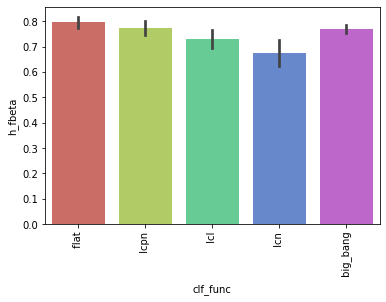

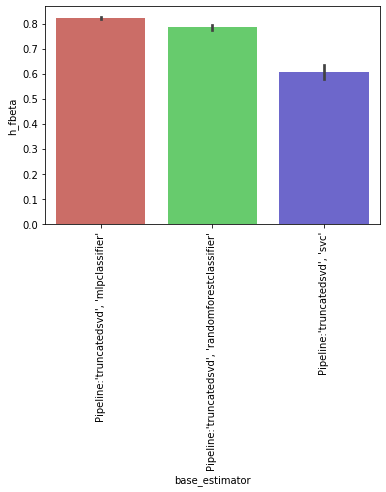

In [16]:
metric = 'h_fbeta'
columns_to_test = ['clf_func', 'base_estimator']

plot_columns(results, columns_to_test, metric)

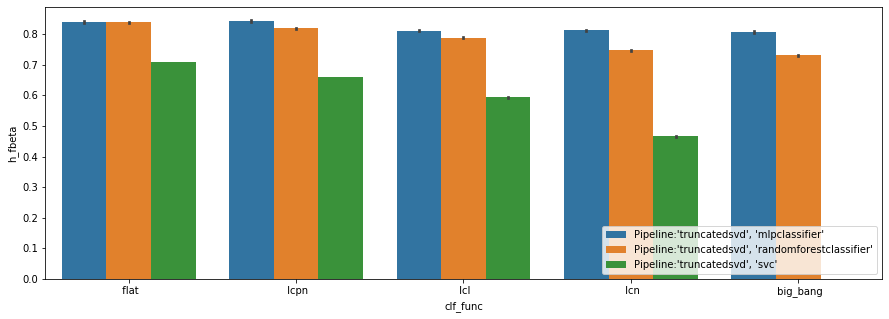

In [17]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=results, x='clf_func', y='h_fbeta', hue='base_estimator')
ax.legend(loc=4)
pass

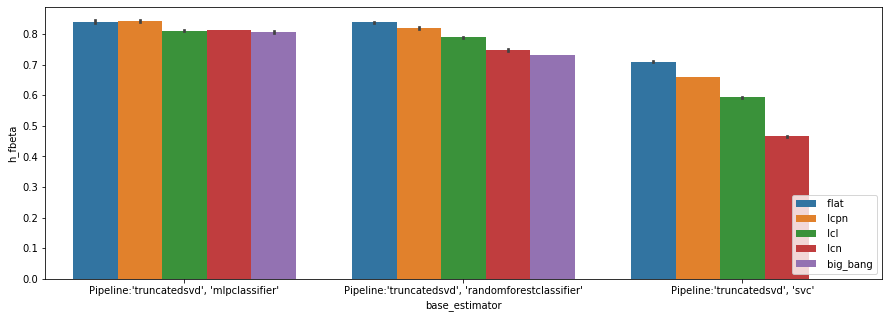

In [18]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=results, x='base_estimator', y='h_fbeta', hue='clf_func')
ax.legend(loc=4)
pass

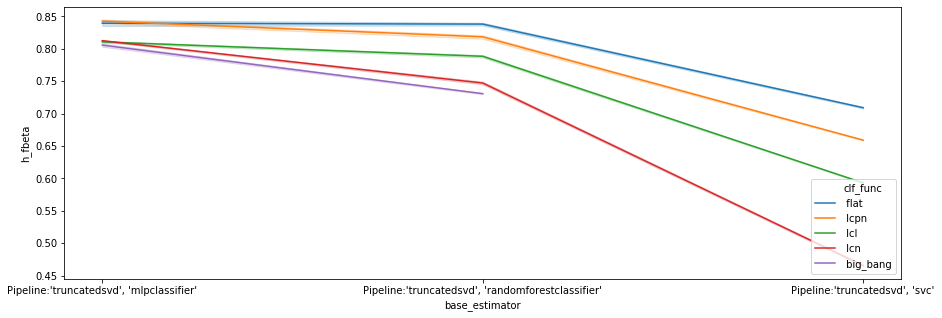

In [19]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=results, x='base_estimator', y='h_fbeta', hue='clf_func')
ax.legend(loc=4)
pass

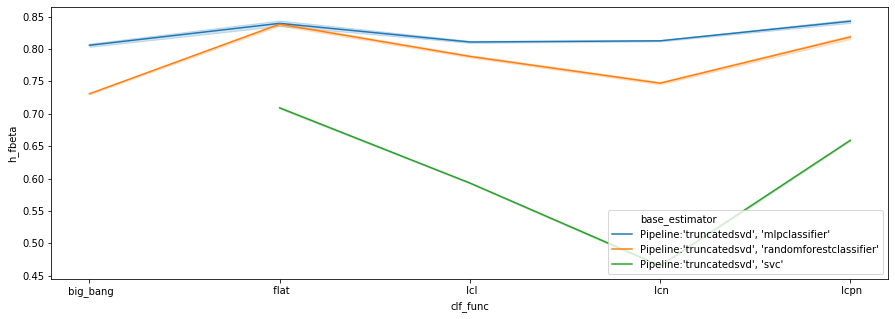

In [20]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=results, x='clf_func', y='h_fbeta', hue='base_estimator')
ax.legend(loc=4)
pass

# Wnioski

### LCN
Zalety:
- binarne klasyfikatory są łatwe do interpretacji;
- podejście wieloetykietowe;

Wady:
- bardzo dużo klasyfikatorów - bardzo duża złożoność obliczeniowa;
- są wysokie szanse na to, że pojawi się niekonsekwencja;
- dla wykorzystanego zbioru danych osiągnięto bardzo słabe wyniki przy tym podejściu.

### LCL
Zalety:
- mniej klasyfikatorów niż LCPN i LCN;
- tylko tyle klasyfikatorów, ile jest poziomów hierarchii;

Wady:
- niekonsekwencja jest bardzo prawdopodobna;
- na niższych poziomach może być bardzo dużo klas do wyboru;
- nie uwzględnia relacji między rodzicem a dzieckiem;
- dla wykorzystanego zbioru danych osiągnięto niezbyt dobre wyniki.


### LCPN
Zalety:
- brak niekonsekwencji (schodzimy w dół po jednej ścieżce);
- dość logiczne i intuicyjne podejście;
- dla wykorzystanego zbioru danych osiągnięto dość dobre wyniki;

Wady:
- dużo klasyfikatorów - duża złożoność obliczeniowa.


### Big-Bang
Zalety:
- może być wieloetykietowy (multi-label);
- dość prosty do zaimplementowania;

Wady:
- może nastąpić niekonsekwencja (mogą być wybrane dwie klasy-liście lub klasa rodzica i niepasującego do niego dziecka);
- klasyfikatory wieloetykietowe mają większą złożoność obliczeniową niż zwykłe jednoetykietowe;
- dla wykorzystanego zbioru danych osiągnięto najgorsze wyniki (nie widać tego na pierwszym wykresie, ponieważ do Big Bang nie użyto klasyfikatora SVC, który miał najgorsze wyniki i obniżył średnią dla pozostałych klasyfikatorów).


### Flat
Zalety:
- jeden klasyfikator - szybkie działanie;
- prostota zbudowania oraz implementacji;
- brak niekonsekwensji;
- dla wykorzystanego zbioru danych osiągnięto najlepsze wyniki;

Wady:
- nie wykorzystujemy informacji o hierarchiczności;
- nie może się zatrzymać na poziomie rodzica, operuje tylko na liściach.
